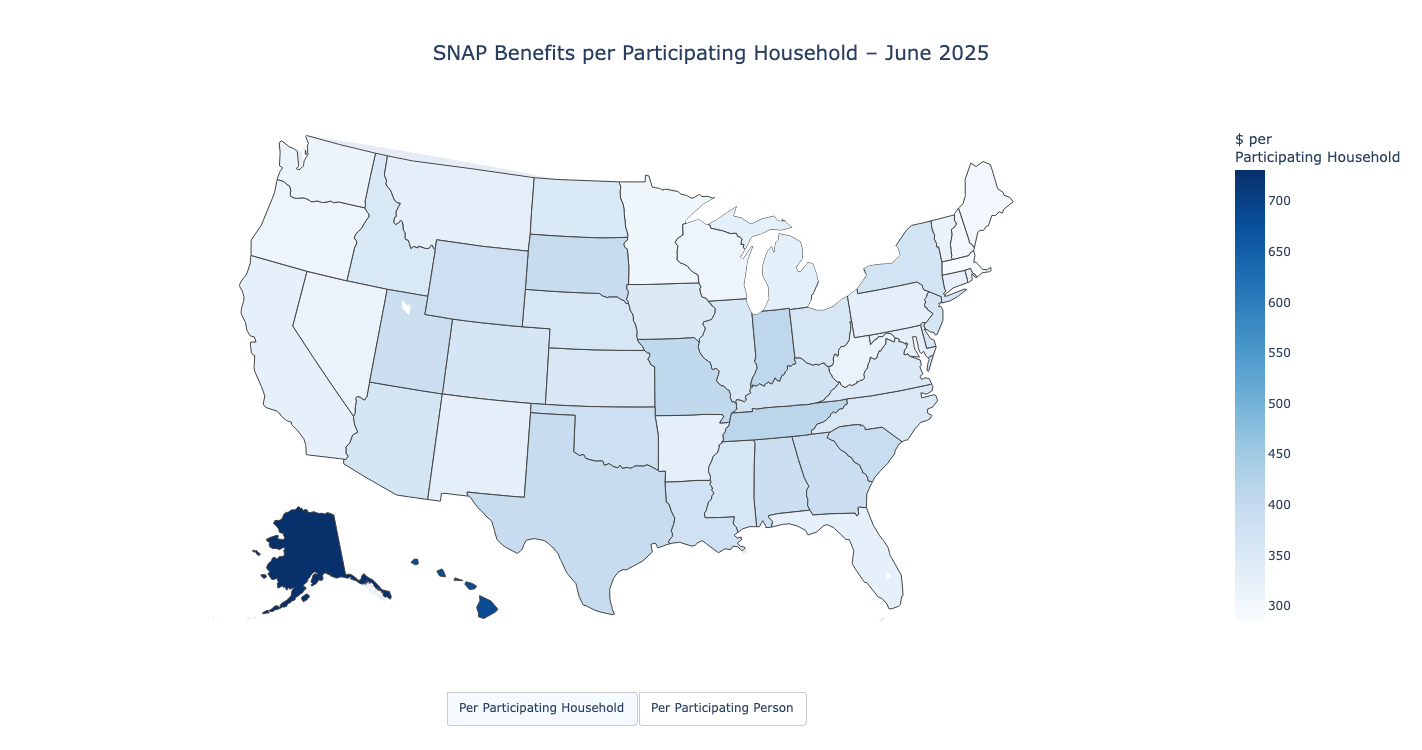


SNAP BENEFITS SUMMARY – June 2025

Total Benefits: $7.79 Billion
Participating Persons: 41.52 Million
Participating Households: 22.31 Million

Average SNAP per Participating Person: $190.44
Average SNAP per Participating Household: $362.10

Top 5 States by SNAP per Participating Person:
  Hawaii: $355.21
  Alaska: $343.02
  New York: $217.81
  Tennessee: $204.67
  Rhode Island: $200.21

Top 5 States by SNAP per Participating Household:
  Alaska: $730.25
  Hawaii: $685.25
  Tennessee: $412.06
  Indiana: $408.84
  Missouri: $403.82


In [5]:
import pandas as pd
import plotly.graph_objects as go

# Read CSV files
df_benefits = pd.read_csv("snap-benefits-9.csv")
df_households = pd.read_csv("snap-households-9.csv")
df_persons = pd.read_csv("snap-persons-9.csv")

# Clean column names
df_persons.columns = ['State', 'June_2024', 'May_2025', 'June_2025', 'Pct_Change_vs_May', 'Pct_Change_vs_June_2024']
df_households.columns = ['State', 'June_2024', 'May_2025', 'June_2025', 'Pct_Change_vs_May', 'Pct_Change_vs_June_2024']
df_benefits.columns = ['State', 'June_2024', 'May_2025', 'June_2025', 'Pct_Change_vs_May', 'Pct_Change_vs_June_2024']

# Clean state names
for df_ in [df_persons, df_households, df_benefits]:
    df_['State'] = df_['State'].str.strip()

# Numeric cleaning function
def clean_numeric(series):
    return pd.to_numeric(series.astype(str).str.replace(',', '').str.replace('--', ''), errors='coerce')

# Extract June 2025 values
df_persons['Persons'] = clean_numeric(df_persons['June_2025'])
df_households['Households'] = clean_numeric(df_households['June_2025'])
df_benefits['Benefits'] = clean_numeric(df_benefits['June_2025'])

# Merge datasets
df = (
    df_persons[['State', 'Persons']]
    .merge(df_households[['State', 'Households']], on='State')
    .merge(df_benefits[['State', 'Benefits']], on='State')
)

# Exclude territories
territories = ['American Samoa', 'Guam', 'Puerto Rico', 'Virgin Islands', 
               'Northern Mariana', 'Northern Mariana Islands']
df = df[~df['State'].isin(territories)].copy()

# Remove rows with missing values
df = df.dropna(subset=['Persons', 'Households', 'Benefits'])

# Calculate metrics
df['SNAP_Per_Person'] = df['Benefits'] / df['Persons']
df['SNAP_Per_Household'] = df['Benefits'] / df['Households']

# State abbreviation lookup
state_abbrev = {
    'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO',
    'Connecticut': 'CT','Delaware': 'DE','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID',
    'Illinois': 'IL','Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
    'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
    'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
    'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR',
    'Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD',
    'Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virginia': 'VA',
    'Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',
    'District of Columbia': 'DC'
}

df['State_Code'] = df['State'].map(state_abbrev)
df = df.dropna(subset=['State_Code'])

# Hover text
df['hover_text'] = (
    '<b>' + df['State'] + '</b><br>' +
    '------------------------------<br>' +
    '<b>Total Benefits:</b> $' + (df['Benefits'] / 1e6).round(1).astype(str) + 'M<br>' +
    '<b>Participating Persons:</b> ' + (df['Persons'] / 1e3).round(1).astype(str) + 'K<br>' +
    '<b>Participating Households:</b> ' + (df['Households'] / 1e3).round(1).astype(str) + 'K<br>' +
    '------------------------------<br>' +
    '<b>SNAP per Participating Person:</b> $' + df['SNAP_Per_Person'].round(2).astype(str) + '<br>' +
    '<b>SNAP per Participating Household:</b> $' + df['SNAP_Per_Household'].round(2).astype(str)
)

# Choropleth map
fig = go.Figure()

fig.add_trace(go.Choropleth(
    locations=df['State_Code'],
    z=df['SNAP_Per_Household'],
    locationmode='USA-states',
    colorscale='Blues',
    colorbar=dict(title="$ per<br>Participating Household", x=1.02),
    text=df['hover_text'],
    hovertemplate='%{text}<extra></extra>',
    visible=True,
    name='SNAP per Participating Household'
))

fig.add_trace(go.Choropleth(
    locations=df['State_Code'],
    z=df['SNAP_Per_Person'],
    locationmode='USA-states',
    colorscale='Greens',
    colorbar=dict(title="$ per<br>Participating Person", x=1.02),
    text=df['hover_text'],
    hovertemplate='%{text}<extra></extra>',
    visible=False,
    name='SNAP per Participating Person'
))

# Toggle buttons (below map)
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=0.5,
            xanchor="center",
            y=-0.12,
            buttons=[
                dict(
                    label="Per Participating Household",
                    method="update",
                    args=[
                        {"visible": [True, False]},
                        {"title.text": "SNAP Benefits per Participating Household – June 2025"}
                    ]
                ),
                dict(
                    label="Per Participating Person",
                    method="update",
                    args=[
                        {"visible": [False, True]},
                        {"title.text": "SNAP Benefits per Participating Person – June 2025"}
                    ]
                ),
            ],
            font=dict(size=12),
            bgcolor="white",
            bordercolor="#CCC"
        )
    ]
)

# Layout
fig.update_layout(
    title=dict(
        text='SNAP Benefits per Participating Household – June 2025',
        x=0.5,
        font=dict(size=20)
    ),
    geo=dict(
        scope='usa',
        projection=go.layout.geo.Projection(type='albers usa'),
        showlakes=True,
        lakecolor='white'
    ),
    width=1100,
    height=750,
    margin=dict(t=120, b=120, l=50, r=50),
    paper_bgcolor='white',
    hoverlabel=dict(
        bgcolor="white",
        font_size=13,
        font_family="Arial"
    )
)

fig.show()

# Summary statistics
print("\n" + "="*60)
print("SNAP BENEFITS SUMMARY – June 2025")
print("="*60)

print(f"\nTotal Benefits: ${df['Benefits'].sum() / 1e9:.2f} Billion")
print(f"Participating Persons: {df['Persons'].sum() / 1e6:.2f} Million")
print(f"Participating Households: {df['Households'].sum() / 1e6:.2f} Million")

print(f"\nAverage SNAP per Participating Person: ${df['SNAP_Per_Person'].mean():.2f}")
print(f"Average SNAP per Participating Household: ${df['SNAP_Per_Household'].mean():.2f}")

print("\nTop 5 States by SNAP per Participating Person:")
for _, row in df.nlargest(5, 'SNAP_Per_Person').iterrows():
    print(f"  {row['State']}: ${row['SNAP_Per_Person']:.2f}")

print("\nTop 5 States by SNAP per Participating Household:")
for _, row in df.nlargest(5, 'SNAP_Per_Household').iterrows():
    print(f"  {row['State']}: ${row['SNAP_Per_Household']:.2f}")
